In [1]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

%matplotlib inline
import matplotlib.pyplot as plt

# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
# from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

from PIL import Image
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
import matplotlib.cm as cm
from matplotlib.pyplot import subplots

from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import matplotlib

zsh:1: command not found: nvcc
torch:  2.0 ; cuda:  2.0.0.dev20230228
detectron2: 0.6


In [2]:
ROOT_DIR = "/Users/andrijapaurevic/Documents/uWaterloo/research/mainCSG/QuantumDotControl/autotuning/data/csd"

MODEL_DATA_DIR = os.path.join(ROOT_DIR, "processed")

MODEL_TRAIN_DATA_DIR = os.path.join(MODEL_DATA_DIR,"train")
MODEL_VAL_DATA_DIR = os.path.join(MODEL_DATA_DIR,"val")
MODEL_TEST_DATA_DIR = os.path.join(MODEL_DATA_DIR,"test")


# Annotation Dataset

In [3]:
class_dict = {0: "ND", 0.5: "LD", 1: "CD", 1.5: "RD", 2: "DD"}

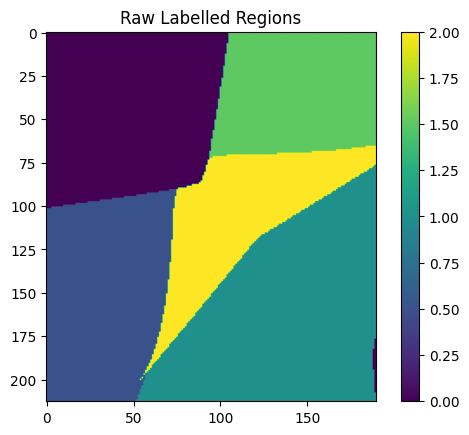

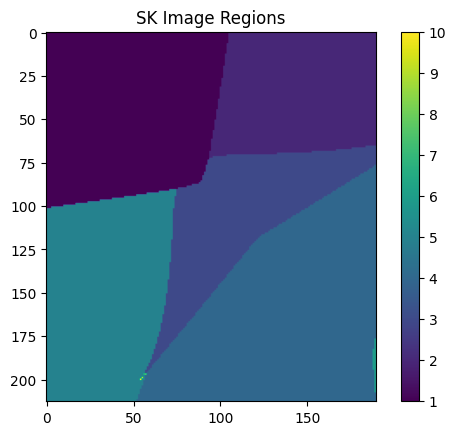

(0.0, 213.0)

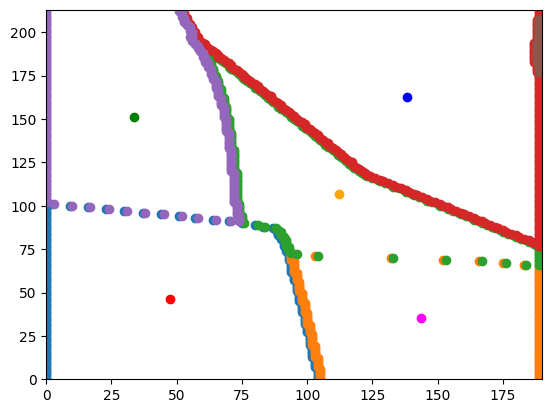

In [95]:
import skimage as sk
# raw
# file_path = "/Users/andrijapaurevic/Documents/uWaterloo/research/mainCSG/QuantumDotControl/autotuning/data/csd/raw/20200714-140115023515_cr1279.npy"
# file_path = "/Users/andrijapaurevic/Documents/uWaterloo/research/mainCSG/QuantumDotControl/autotuning/data/csd/raw/20171118-125846183949.npy"
# file_path = "/Users/andrijapaurevic/Documents/uWaterloo/research/mainCSG/QuantumDotControl/autotuning/data/csd/raw/20200711-161944699948_cr145.npy"
file_path = "/Users/andrijapaurevic/Documents/uWaterloo/research/mainCSG/QuantumDotControl/autotuning/data/csd/raw/20200714-172019089587_cr1444.npy"

# Loads, *.npy file, extracts CSD
qflow_data = np.load(file_path, allow_pickle=True).item()

voltage_P1_key = "x" if "d_" in file_path else "V_P1_vec"
voltage_P2_key = "y" if "d_" in file_path else "V_P2_vec"
N = len(qflow_data[voltage_P1_key])
M = len(qflow_data[voltage_P2_key])

try:
    csd_qd_states = np.array([
        data['state'] for data in qflow_data['output']
    ]).reshape((N,M) if N > M else (M,N))
    background = 0
    correction = 1

except TypeError:

    csd_qd_states = np.array(qflow_data['output']['state']).reshape((N,M) if N > M else (M,N))
    background = -1
    correction = 2

csd_qd_labelled_regions = sk.measure.label((correction * csd_qd_states).astype(np.uint8), background=background, connectivity=1)

csd_qd_regions = sk.measure.regionprops(csd_qd_labelled_regions)

num_of_predicted_regions = len(csd_qd_regions)

if num_of_predicted_regions > 10:
    try:
        csd_qd_states = np.array([
            data['state'] for data in qflow_data['output']
        ])
        background = 0
        correction = 1

    except TypeError:

        csd_qd_states = np.array(qflow_data['output']['state'])
        background = -1
        correction = 2
        
    csd_qd_states = csd_qd_states.reshape(M,N)

    csd_qd_labelled_regions = sk.measure.label((correction * csd_qd_states).astype(np.uint8), background=background, connectivity=1)

    csd_qd_regions = sk.measure.regionprops(csd_qd_labelled_regions)

plt.imshow(csd_qd_states)
plt.title("Raw Labelled Regions")
plt.colorbar()
plt.show()

plt.imshow(csd_qd_labelled_regions)
plt.title("SK Image Regions")
plt.colorbar()
plt.show()

csd_object_list = []
regions_list = []

fig, ax = plt.subplots()
patches = []

for index in range(len(csd_qd_regions)):
    region_info = {}

    region_coords = csd_qd_regions[index].coords

    # Get boundaries of coordiantes
    temp = {}
    for row in region_coords:
        key = row[0]
        value = row[1]
        if key not in temp:
            temp[key] = [value, value]  # Initialize with the current value
        else:
            temp[key][0] = min(temp[key][0], value)  # Update minimum value
            temp[key][1] = max(temp[key][1], value)  # Update maximum value
    region_coords = np.array([[key, minmax[0]] for key, minmax in temp.items()] + [[key, minmax[1]] for key, minmax in temp.items()])

    y,x = region_coords.T

    px = x.tolist()
    py = y.tolist()

    def flip_coordinates_horizontal_axis(x_coordinates, y_coordinates, axis):
        flipped_x_coordinates = []
        flipped_y_coordinates = []
        
        for x, y in zip(x_coordinates, y_coordinates):
            distance = (axis - y)
            y_flipped = axis + distance
            flipped_x_coordinates.append(x)
            flipped_y_coordinates.append(y_flipped)
        
        return flipped_x_coordinates, flipped_y_coordinates

    def find_polygon_centroid(coordinates):

        n = len(coordinates)
        
        # Calculate the signed area of the polygon
        signed_area = 0
        for i in range(n):
            x_i, y_i = coordinates[i]
            x_j, y_j = coordinates[(i + 1) % n]
            signed_area += (x_i * y_j - x_j * y_i)
        signed_area *= 0.5
        
        # Calculate the coordinates of the centroid
        centroid_x = 0
        centroid_y = 0
        for i in range(n):
            x_i, y_i = coordinates[i]
            x_j, y_j = coordinates[(i + 1) % n]
            factor = x_i * y_j - x_j * y_i
            centroid_x += (x_i + x_j) * factor
            centroid_y += (y_i + y_j) * factor
        centroid_x /= (6 * signed_area)
        centroid_y /= (6 * signed_area)
        
        return centroid_x, centroid_y

    def organize_array_clockwise(arr):
            
        # Calculate the centroid of the points
        centroid = np.mean(arr, axis=0)

        # Calculate the angle of each point with respect to the centroid
        angles = np.arctan2(arr[:, 1] - centroid[1], arr[:, 0] - centroid[0])

        # Sort the points based on the angles in clockwise order
        indices = np.argsort(angles)
        sorted_arr = arr[indices]

        return sorted_arr      

    # px, py = flip_coordinates_horizontal_axis(px, py, csd_qd_states.shape[0]/2)
    poly = [(x, y) for x, y in zip(px, py)]
    poly = np.array([p for x in poly for p in x]).reshape(-1,2)

    if len(px) <= 2 or len(py) <= 2:
        # print("Ignoring polygon from ", npy_file, "because a polygon was too small for detectron2.")
        continue
    
    poly_clockwise = organize_array_clockwise(poly)
    x0, y0 = find_polygon_centroid(poly_clockwise)
    x0_, y0_ = flip_coordinates_horizontal_axis([x0], [y0], axis=csd_qd_states.shape[0]/2)
    x0_, y0_ = flip_coordinates_horizontal_axis(y0_, x0_, axis=csd_qd_states.shape[1]/2)
    x0_val, y0_val = x0_[0], y0_[0]

    qd_num = class_dict[csd_qd_states[csd_qd_states.shape[0] - int(x0_val), csd_qd_states.shape[1] - int(y0_val)] ]
    # plt.scatter([csd_qd_states.shape[0] -int(x0_val)], [csd_qd_states.shape[1] - int(y0_val)], c="black")
    patches.append(matplotlib.patches.Polygon(poly_clockwise))
    category_dict = {"ND": "red", "LD": "green", "CD": "blue", "RD": "magenta", "DD": "orange"}
    plt.scatter([x0],[y0], c=category_dict[qd_num])
    plt.scatter(px,py)
    

# p = PatchCollection(patches, cmap=matplotlib.cm.jet, alpha=0.4)
# colors = 100*np.random.rand(len(patches))
# p.set_array(np.array(colors))
# ax.add_collection(p)
# ax.autoscale_view()

plt.xlim(0,N)
plt.ylim(0,M)




6
ND
212 212
RD
152 152
DD
300 300
CD
254 254
LD
252 252
ND
122 122


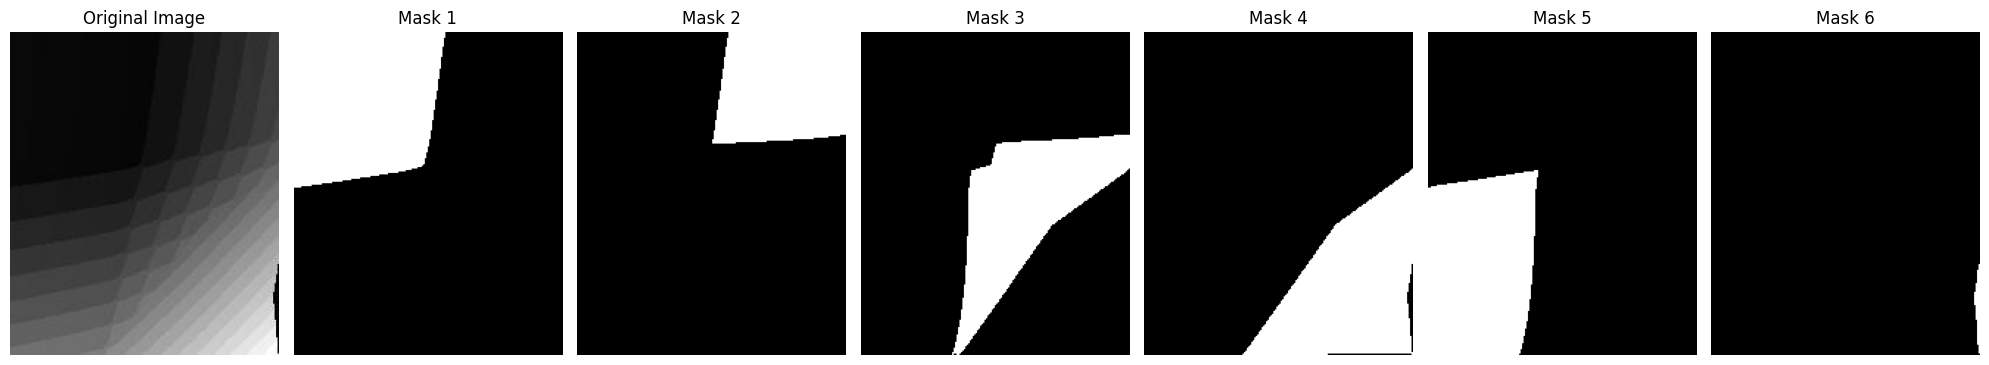

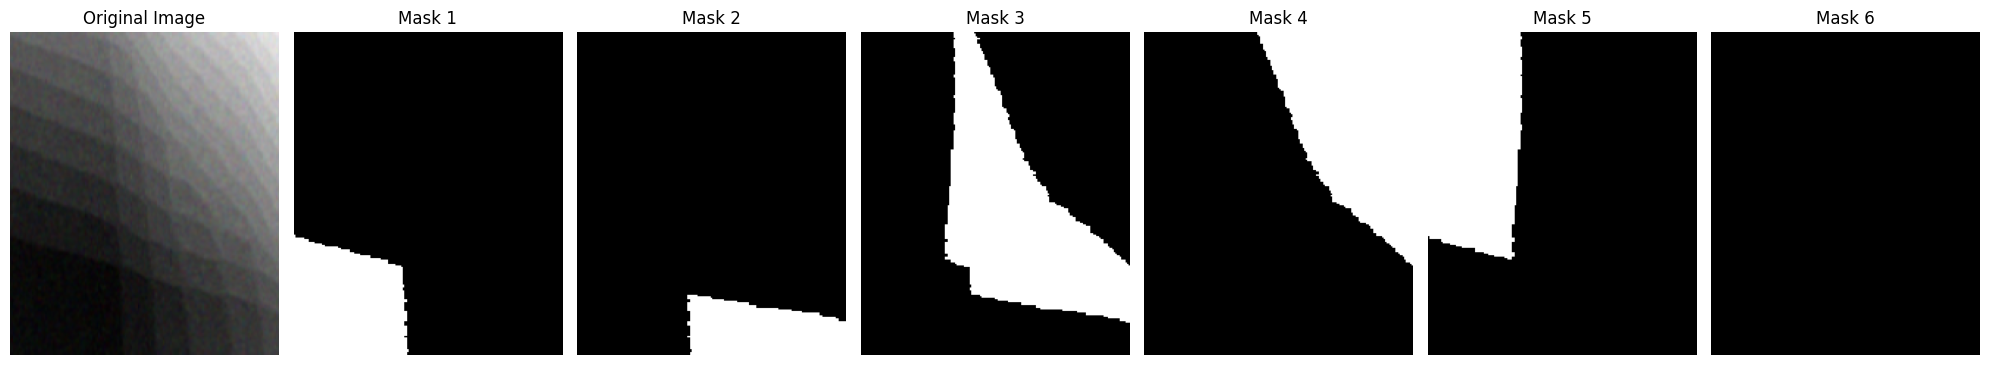

In [110]:
# !python -m pip install albumentations
# !python -m pip install imantics
import albumentations as A
from imantics import Polygons, Mask

image_path = "/Users/andrijapaurevic/Documents/uWaterloo/research/mainCSG/QuantumDotControl/autotuning/data/csd/processed/train/20171118-125247500300.jpg"
# image_path = "/Users/andrijapaurevic/Documents/uWaterloo/research/mainCSG/QuantumDotControl/autotuning/data/csd/processed/train/20200712-153345916230_cr520.jpg"
image_path = "/Users/andrijapaurevic/Documents/uWaterloo/research/mainCSG/QuantumDotControl/autotuning/data/csd/processed/train/20200712-175323893135_cr924.jpg"
def augment_image(image_path):

    img_dir = os.path.dirname(image_path)

    def get_augmentation():
        return A.Compose([
            A.VerticalFlip(p=0.7),
            A.Rotate(limit=20, p=0.8),
            A.RandomBrightnessContrast(brightness_limit=(0,0.4), contrast_limit=(0, 0.1), p=0.8),
            A.GaussNoise(var_limit=(30.0,120.0), p=0.7),
            A.GridDistortion(distort_limit=0.4, p=1),
            A.Affine(scale=(1,1.3), p=0.9),
            A.RandomToneCurve(p=0.5),
            A.AdvancedBlur(p=0.8),
            A.RingingOvershoot(p=0.5),
            # A.GlassBlur(p=1)
        ], is_check_shapes=False)

    def polygon_to_mask(polygon_coords, image_shape):
        mask = np.zeros(image_shape[:2])
        cv2.fillPoly(mask, [polygon_coords], 255)
        return np.array(mask)

    def PolyArea(x,y):
        return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

    def plot_image_and_mask(image, masks):
        # Plot the original image
        plt.figure(figsize=(20, 5))
        plt.subplot(1, 1 + len(masks), 1)
        plt.title('Original Image')
        plt.imshow(image)
        plt.axis('off')

        # Plot each mask
        for idx, mask in enumerate(masks):
            plt.subplot(1, 1 + len(masks), idx + 2)
            plt.title(f'Mask {idx+1}')
            plt.imshow(mask, cmap='gray')
            plt.axis('off')

        plt.tight_layout()
        plt.show()

    def convert_mask_to_polygon_coordinates(mask):
        polygons = Mask(mask).polygons()
        if len(polygons.points) != 0:
            polygon_area = []
            for i in range(len(polygons.points)):
                x,y = zip(*polygons.points[i])
                polygon_area.append(PolyArea(x,y))
            idx = np.argmax(polygon_area)
            
            return polygons.points[idx]
        else: 
            return []

    image = cv2.imread(image_path)

    json_file = os.path.join(img_dir, "via_region_data.json")
    
    with open(json_file) as f:
        imgs_anns = json.load(f)

    masks_list =[]

    filename = os.path.join(img_dir, image_path)
    v = imgs_anns[filename]

    annos = v["regions"]
    print(len(annos))
    for _, anno in annos.items():
        regions = anno["region_attributes"]

        anno = anno["shape_attributes"]
        px = anno["all_points_x"]
        py = anno["all_points_y"]

        print(regions['label'])
        print(len(px), len(py))
        poly = np.array([(x, y) for x, y in zip(px, py)])
        # poly = [p for x in poly for p in x]

        # x, y = zip(*poly_reconstructed)
        # plt.scatter(x,y)
        # plt.xlim([0,250])
        # plt.ylim([0,250])
        # plt.show()

        masks_list.append(polygon_to_mask(poly, image.shape))


    masks = masks_list

    plot_image_and_mask(image,masks)

    augmentation = get_augmentation()
    augmented = augmentation(image=image, masks=masks)
    augmented_image = augmented['image']
    augmented_masks = augmented['masks']

    # for mask in augmented_masks:
    #     polygon = convert_mask_to_polygon_coordinates(mask)
    #     mask_reconstruct = polygon_to_mask(polygon, image.shape)
    #     # plt.imshow(mask_reconstruct)
    #     # plt.show()
    plot_image_and_mask(augmented_image,augmented_masks)

augment_image(image_path)


## Exp Small Data Exploration



In [65]:
test_file = "/Users/andrijapaurevic/Documents/uWaterloo/research/mainCSG/QuantumDotControl/autotuning/data/csd/raw/d_0_file_000.npy"

# Loads, *.npy file, extracts CSD
qflow_data = np.load(test_file, allow_pickle=True).item()

voltage_P1_key = "x" if "d_" in test_file else "V_P1_vec"
voltage_P2_key = "y" if "d_" in test_file else "V_P2_vec"
N = len(qflow_data[voltage_P1_key])
M = len(qflow_data[voltage_P2_key])

def convert_label_to_region_mask(data, label):

    label_index_to_region_dict = {0: 0.0, 1: 0.5, 2:1 , 3: 1.5, 4: 2}
    region_num = label_index_to_region_dict[np.argmax(label)]
    return region_num * np.ones_like(data)

# print(qflow_data['label'])
# print(convert_label_to_region_mask(qflow_data['sensor'], qflow_data['label']))


# Detectron2 Dataset

In [88]:
from detectron2.structures import BoxMode

def get_csd_dicts(img_dir):
    json_file = os.path.join(img_dir, "via_region_data.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, v in enumerate(imgs_anns.values()):
        record = {}
        
        filename = os.path.join(img_dir, v["filename"])
        
        height, width = v["height"], v["width"]
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
      
        annos = v["regions"]
        objs = []
        for _, anno in annos.items():
            regions = anno["region_attributes"]
            
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]

            
            poly = [(x, y) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]
            
            category_dict = {"ND": 0, "LD": 1, "CD": 2, "RD": 3, "DD": 4}
            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": category_dict[regions["label"]],
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

/Users/andrijapaurevic/Documents/uWaterloo/research/mainCSG/QuantumDotControl/autotuning/data/csd/processed/train/20200711-165826049874_cr271_augment1.jpg
/Users/andrijapaurevic/Documents/uWaterloo/research/mainCSG/QuantumDotControl/autotuning/data/csd/processed/train/20200714-134823245177_cr1241_augment1.jpg
/Users/andrijapaurevic/Documents/uWaterloo/research/mainCSG/QuantumDotControl/autotuning/data/csd/processed/train/20200712-165248102692_cr838_augment1.jpg
/Users/andrijapaurevic/Documents/uWaterloo/research/mainCSG/QuantumDotControl/autotuning/data/csd/processed/train/20200712-164611999788_cr821_augment4.jpg
/Users/andrijapaurevic/Documents/uWaterloo/research/mainCSG/QuantumDotControl/autotuning/data/csd/processed/train/20200712-155017070910_cr601_augment4.jpg
/Users/andrijapaurevic/Documents/uWaterloo/research/mainCSG/QuantumDotControl/autotuning/data/csd/processed/train/20200712-154346679962_cr573.jpg
/Users/andrijapaurevic/Documents/uWaterloo/research/mainCSG/QuantumDotControl/

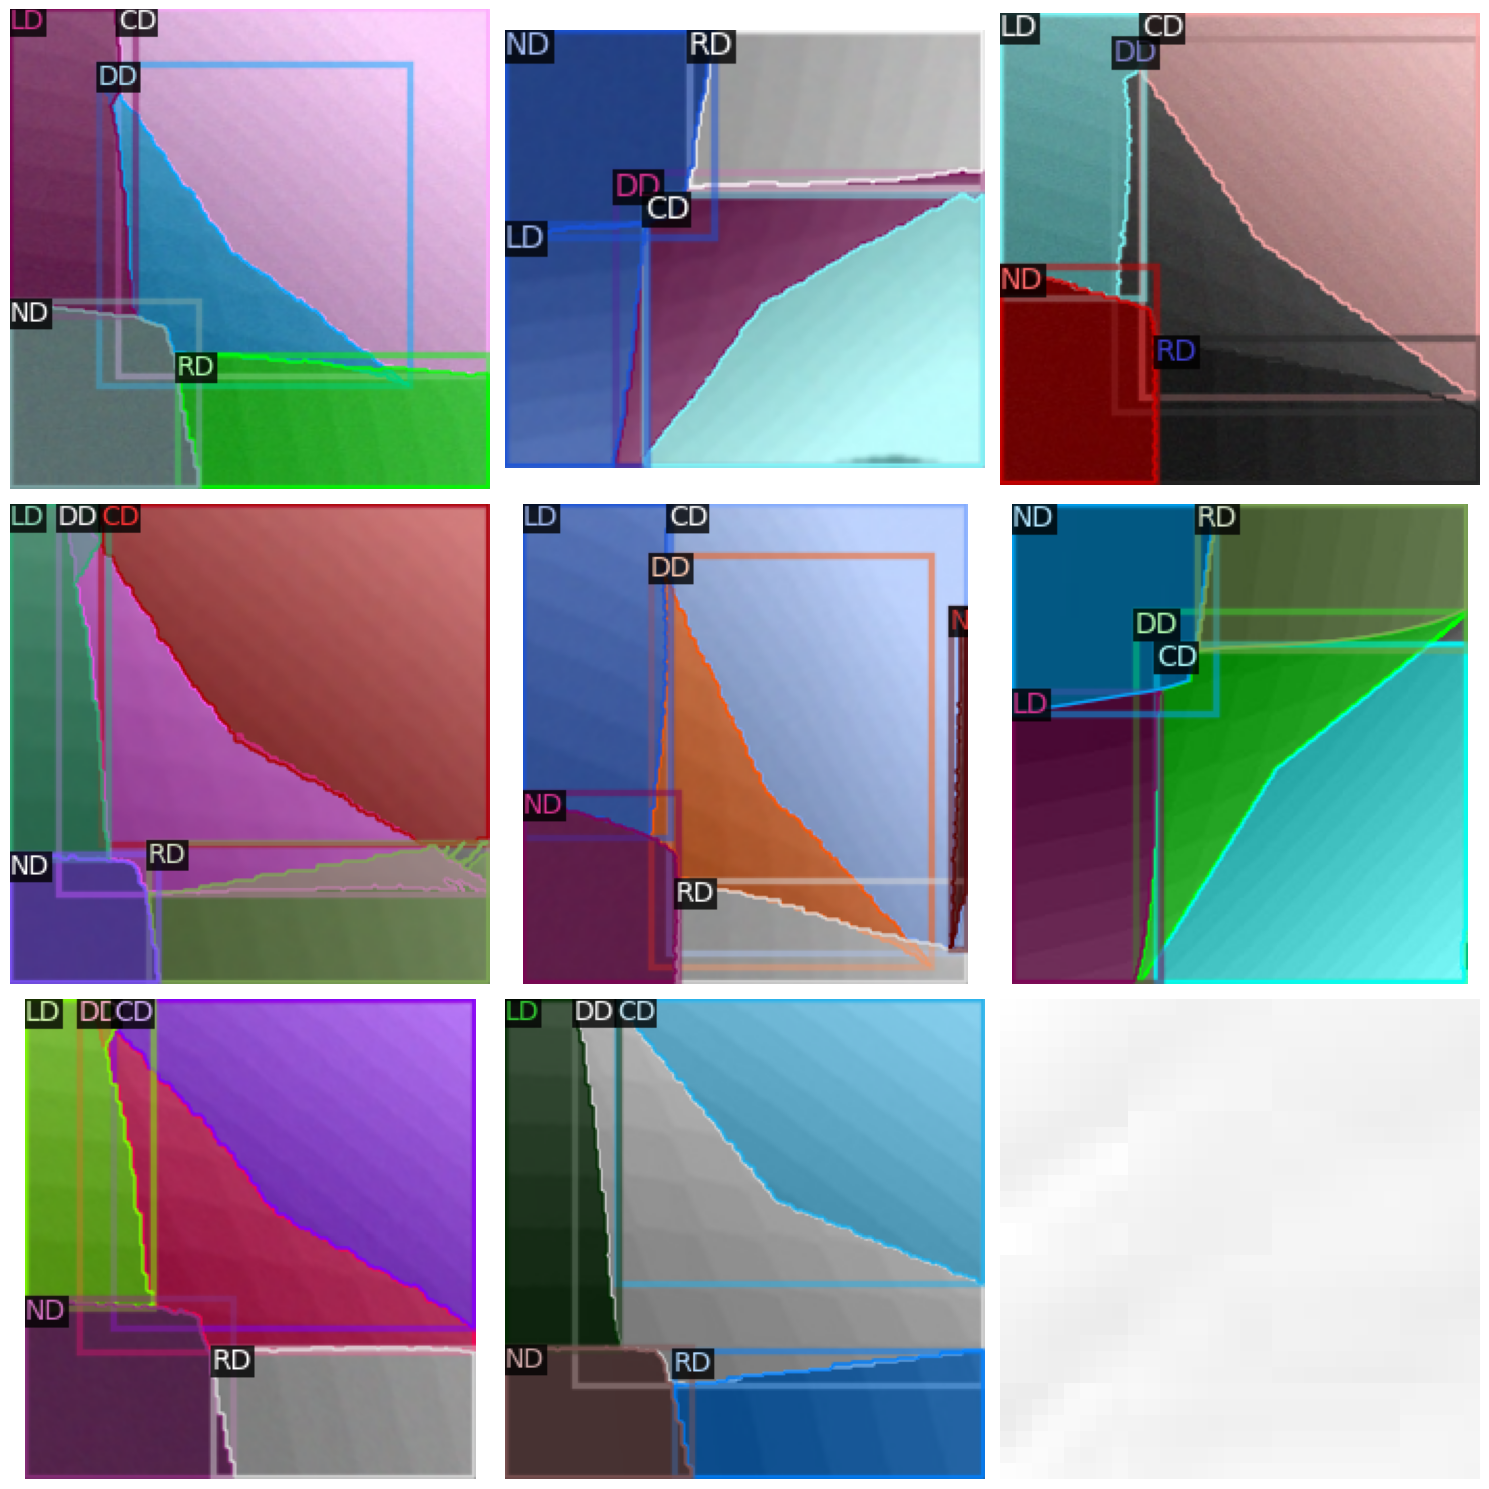

In [99]:
DatasetCatalog.clear()
MetadataCatalog.clear()

for d in ["train", "val", "test"]:
    DatasetCatalog.register("csd_" + d, lambda d=d: get_csd_dicts(os.path.join(MODEL_DATA_DIR,d)))
    MetadataCatalog.get("csd_" + d).set(thing_classes=["ND", "LD", "CD", "RD", "DD"])
    # MetadataCatalog.get("csd_" + d).set(thing_colors=[(255,0,0),(0,255,0),(0,0,255)])

csd_metadata = MetadataCatalog.get("csd_train")
csd_test_metadata = MetadataCatalog.get("csd_test")

dataset_dicts = get_csd_dicts(MODEL_TRAIN_DATA_DIR)

num_of_display_images = 9

num_cols = min(3, num_of_display_images)  # Maximum of 3 columns
num_rows = int(np.ceil(num_of_display_images / num_cols))
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

for i, d in enumerate(random.sample(dataset_dicts, num_of_display_images)):
    print(d["file_name"])
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=csd_metadata, scale=1)
    out = visualizer.draw_dataset_dict(d)
    if num_rows > 1:
        ax = axs[i // num_cols, i % num_cols]
    else: 
        ax = axs[i % num_cols]
    ax.imshow(out.get_image()[:, :, ::-1])
    ax.axis("off")

plt.tight_layout()
plt.show()



In [295]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("csd_train",)
cfg.DATASETS.TEST = ()
cfg.MODEL.DEVICE = "cpu"

cfg.DATALOADER.NUM_WORKERS = 2
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 5  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300 # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join("/Users/andrijapaurevic/Documents/uWaterloo/research/mainCSG/QuantumDotControl/autotuning/coarse_tuning/output", "model_charge_sensor_5000.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8  # set a custom testing threshold
predictor = DefaultPredictor(cfg)


[06/21 17:44:21 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /Users/andrijapaurevic/Documents/uWaterloo/research/mainCSG/QuantumDotControl/autotuning/coarse_tuning/output/model_charge_sensor_5000.pth ...


# Validation Dataset

All masks are false?:  False


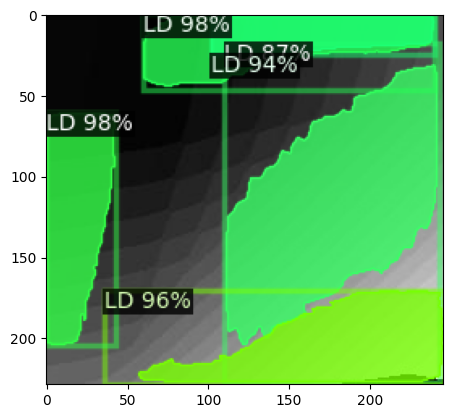

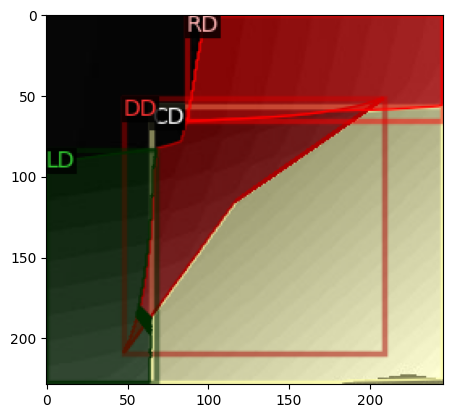

In [296]:
from detectron2.utils.visualizer import ColorMode

dataset_dicts = get_csd_dicts(MODEL_VAL_DATA_DIR)
for d in random.sample(dataset_dicts, 1):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format

    v = Visualizer(im[:, :, ::-1],
                   metadata=csd_metadata, 
                   scale=1,    # remove the colors of unsegmented pixels. This option is only available for segmentation models
                   instance_mode=ColorMode.SEGMENTATION   # remove the colors of unsegmented pixels
    )

    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(out.get_image())
    plt.show()
    
    plt.cla()
    plt.clf()
    plt.close()
    visualizer = Visualizer(im[:, :, ::-1], metadata=csd_metadata, scale=1)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image()[:, :, ::-1],cmap=cm.summer)
    plt.show()

# Experimental Dataset

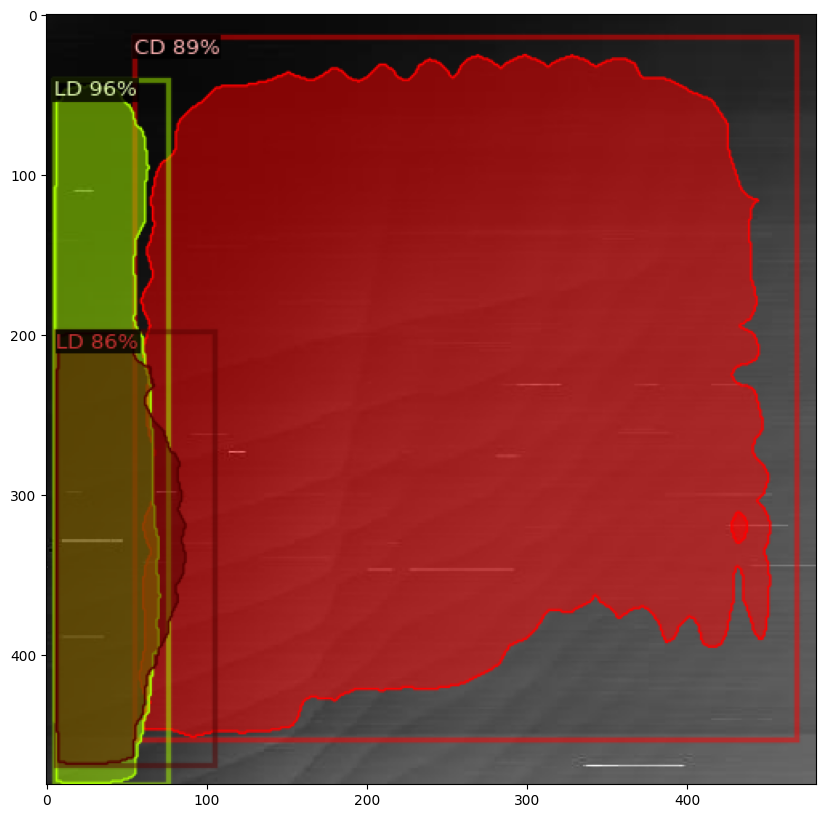

In [297]:
im = cv2.imread("/Users/andrijapaurevic/Documents/uWaterloo/research/mainCSG/QuantumDotControl/autotuning/data/csd/processed/test/exp_large_02.jpg")
im = cv2.rotate(im, cv2.ROTATE_180)
outputs = predictor(im)

v = Visualizer(im[:, :, ::-1], csd_test_metadata, scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize = (14, 10))
plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))